In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import joblib

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler

import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
from mne.preprocessing import ICA

from braindecode.datasets import create_from_mne_raw, create_from_mne_epochs
from braindecode.preprocessing import create_windows_from_events


sys.path.append('../models')
from eegconformer import EEGConformer


# Training EEG Conformer cross-subject

Typically achieves around 68% testing accuracy.

### Loading data and preprocessing
Using all runs for motor imagery task classifying hands vs. feet on first 50 subjects. 

In [2]:
print(__doc__)
models_dir = '../models/trained/'

tmin, tmax = -1.0, 4.0
subjects = range(1, 51)  # Training on the first 50 subjects
runs = [6, 10, 14]  # Motor imagery: hands vs feet
raws = []

for subject in subjects:
    try:
        # Attempt to load the data for the current subject
        raw_fnames = eegbci.load_data(subject, runs)
        # For each subject, load their raw data and append to the 'raws' list
        raws.extend([read_raw_edf(f, preload=True) for f in raw_fnames])
        print(f"Successfully processed subject {subject}.")
    except Exception as e:
        # If an error occurs, skip to the next subject
        print(f"Error processing subject {subject}: {e}. Skipping to next subject.")
        continue

# Concatenate all Raw objects into a single Raw object
raw = concatenate_raws(raws)

Automatically created module for IPython interactive environment
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Successfully processed subject 1.
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R06.edf...
EDF file detected
Setting channe

### Creating Epochs

In [3]:
print(__doc__)

eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
#raw.annotations.rename(dict(T1="hands", T2="feet"))


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs to train between -1 and 4 seconds

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
event_id = dict(hands=2, feet=3)

epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

epochs_data = epochs.get_data(copy=False)
#epochs_data_train = epochs_train.get_data(copy=False)

Automatically created module for IPython interactive environment
Filtering raw data in 150 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2250 events and 801 original time points ...
7 bad epochs dropped


In [27]:

eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
print(eeg_data.shape)

# Flatten the data for scaling, then scale, and reshape back
scaler = RobustScaler()
eeg_data_flattened = eeg_data.reshape(eeg_data.shape[0], -1)  # Flatten
eeg_data_scaled = scaler.fit_transform(eeg_data_flattened)
scaler_path = '../models/trained/'
joblib.dump(scaler, os.path.join(scaler_path, 'robust_scaler.save'))
eeg_data_scaled = eeg_data_scaled.reshape(eeg_data.shape)  # Reshape back

C:\Users\Hannah\AppData\Local\Temp\ipykernel_2728\2609454942.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)


(2243, 64, 801)


### Splitting into Training and Testing

In [5]:

# Split the data and labels into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(
    eeg_data_scaled,  # Scaled EEG data
    labels, 
    test_size=0.2,  # 20% of the data for testing
    random_state=42 
)
# Encode the training and testing labels
le = LabelEncoder()
encoded_train_y = le.fit_transform(train_y)
encoded_test_y = le.transform(test_y)

# One-hot encode the encoded labels
train_y = pd.get_dummies(encoded_train_y)
test_y = pd.get_dummies(encoded_test_y)

In [6]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1794, 64, 801), (449, 64, 801), (1794, 2), (449, 2))

In [7]:
cuda = torch.cuda.is_available()
print(cuda)
device = "cuda" if cuda else "cpu"

False


In [8]:
cuda_version = torch.version.cuda
cuda_version

### EEG Conformer

In [9]:
seed = 202403

model = EEGConformer(
    n_outputs=2,
    n_chans=64,
    sfreq=160,
    n_times = epochs_data.shape[2],
    n_filters_time=40, 
    filter_time_length=25,
    pool_time_length=75,
    pool_time_stride=15,
    drop_prob=0.7,
    att_depth=3,
    att_heads=10,
    att_drop_prob=0.7,
    final_fc_length='auto', # could be 'auto' or int
    return_features=False, # returns the features before the last classification layer if True
    chs_info=None,
    input_window_seconds=None,
    add_log_softmax=True,
)

print(model)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 64, 801]              [1, 2]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 64, 801]           [1, 47, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 64, 801]           [1, 40, 1, 47]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 64, 801]           [1, 40, 64, 777]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 64, 777]          [1, 40, 1, 777]           102,440                   [64, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 777]           [1, 40, 1, 777]           80             

c:\Users\Hannah\OneDrive\Documents\GitHub\eeg\notebooks\../models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [10]:
if cuda:
    model.cuda()

In [11]:
batch_size = 64

# Convert pandas dataframe to numpy, then find argmax if one-hot encoded
if len(train_y.shape) > 1:  # Check if train_y is one-hot encoded
    train_y_indices = np.argmax(train_y.values, axis=1)
else:
    train_y_indices = train_y.values  

if len(test_y.shape) > 1:  # Check if test_y is one-hot encoded
    test_y_indices = np.argmax(test_y.values, axis=1)
else:
    test_y_indices = test_y.values  

# Convert features and labels to tensors
x_train_tensor = torch.from_numpy(train_X).to(torch.float32).to(device)
y_train_tensor = torch.tensor(train_y_indices).to(torch.long).to(device)  # Use torch.long for class indices

x_test_tensor = torch.from_numpy(test_X).to(torch.float32).to(device)
y_test_tensor = torch.tensor(test_y_indices).to(torch.long).to(device)  # Use torch.long for class indices

# Create datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999))


### Training

In [12]:
def train(model, x_train, y_train, x_test, y_test, save_path= models_dir, n_epochs=100, patience=100):
    """
    the training function with early stopping.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.
    - n_epochs: number of epochs to train the model for.
    - patience: number of epochs to wait without improvement before stopping.
    """
    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    test_loss_list = []

    best_accuracy = 0.0
    epochs_no_improve = 0  
    best_model_wts = None  

    for epoch in range(n_epochs):
        # Training phase
        model.train()  # Set model to training mode
        training_loss = 0.0
        total = 0
        correct = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        # Evaluation phase
        model.eval()  # Set model to evaluation mode
        testing_loss = 0.0
        total = 0
        correct = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            test_loss = testing_loss / len(test_loader)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)
            test_loss_list.append(test_loss)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Early Stopping Check
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model_wts = model.state_dict()  # Save the best model weights
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1  # Increment counter if no improvement
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break  # Exit the loop
    
    if save_path is not None and best_model_wts is not None:
        # Ensure the directory exists
        os.makedirs(save_path, exist_ok=True)
        # Save the best model
        torch.save(best_model_wts, os.path.join(save_path, 'conformer.pth'))
        print("Best model saved with accuracy: {:.4f}".format(best_accuracy))
        # Reload the best model weights
        model.load_state_dict(best_model_wts)
    
    return model, train_acc_list, train_loss_list, test_acc_list, test_loss_list


In [13]:
best_model, train_acc_list, train_loss_list, test_acc_list, test_loss_list = train(model, train_X, test_X, train_y, test_y, n_epochs=250)


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 1/250 - Train Loss: 0.7219, Train Accuracy: 0.4805, Test Loss: 0.7353, Test Accuracy: 0.4878


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Epoch 2/250 - Train Loss: 0.7103, Train Accuracy: 0.5056, Test Loss: 0.7092, Test Accuracy: 0.4855


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 3/250 - Train Loss: 0.7142, Train Accuracy: 0.5117, Test Loss: 0.7000, Test Accuracy: 0.4944


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 4/250 - Train Loss: 0.7098, Train Accuracy: 0.5095, Test Loss: 0.6887, Test Accuracy: 0.5145


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 5/250 - Train Loss: 0.7054, Train Accuracy: 0.5123, Test Loss: 0.7067, Test Accuracy: 0.4922


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 6/250 - Train Loss: 0.7106, Train Accuracy: 0.4978, Test Loss: 0.7097, Test Accuracy: 0.4967


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 7/250 - Train Loss: 0.7051, Train Accuracy: 0.4889, Test Loss: 0.7107, Test Accuracy: 0.4967


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 8/250 - Train Loss: 0.7129, Train Accuracy: 0.5100, Test Loss: 0.7085, Test Accuracy: 0.4967


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 9/250 - Train Loss: 0.7022, Train Accuracy: 0.4961, Test Loss: 0.7010, Test Accuracy: 0.5122


100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Epoch 10/250 - Train Loss: 0.7032, Train Accuracy: 0.5151, Test Loss: 0.6930, Test Accuracy: 0.5189


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 11/250 - Train Loss: 0.7038, Train Accuracy: 0.4994, Test Loss: 0.6948, Test Accuracy: 0.5212


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 12/250 - Train Loss: 0.7063, Train Accuracy: 0.5067, Test Loss: 0.6828, Test Accuracy: 0.5256


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 13/250 - Train Loss: 0.6950, Train Accuracy: 0.5279, Test Loss: 0.6634, Test Accuracy: 0.5412


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 14/250 - Train Loss: 0.6878, Train Accuracy: 0.5312, Test Loss: 0.6842, Test Accuracy: 0.5301


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 15/250 - Train Loss: 0.6905, Train Accuracy: 0.5279, Test Loss: 0.6696, Test Accuracy: 0.5323


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 16/250 - Train Loss: 0.6832, Train Accuracy: 0.5491, Test Loss: 0.6468, Test Accuracy: 0.5212


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 17/250 - Train Loss: 0.6842, Train Accuracy: 0.5674, Test Loss: 0.6444, Test Accuracy: 0.5479


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 18/250 - Train Loss: 0.6746, Train Accuracy: 0.5624, Test Loss: 0.6803, Test Accuracy: 0.5234


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 19/250 - Train Loss: 0.6744, Train Accuracy: 0.5624, Test Loss: 0.6519, Test Accuracy: 0.5546


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 20/250 - Train Loss: 0.6580, Train Accuracy: 0.6054, Test Loss: 0.6456, Test Accuracy: 0.5857


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 21/250 - Train Loss: 0.6601, Train Accuracy: 0.5920, Test Loss: 0.6192, Test Accuracy: 0.6192


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 22/250 - Train Loss: 0.6700, Train Accuracy: 0.5886, Test Loss: 0.6348, Test Accuracy: 0.5813


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 23/250 - Train Loss: 0.6412, Train Accuracy: 0.6187, Test Loss: 0.6400, Test Accuracy: 0.5947


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 24/250 - Train Loss: 0.6403, Train Accuracy: 0.6193, Test Loss: 0.6782, Test Accuracy: 0.5791


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 25/250 - Train Loss: 0.6286, Train Accuracy: 0.6399, Test Loss: 0.7651, Test Accuracy: 0.5702


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 26/250 - Train Loss: 0.6300, Train Accuracy: 0.6304, Test Loss: 0.6801, Test Accuracy: 0.5857


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 27/250 - Train Loss: 0.6306, Train Accuracy: 0.6265, Test Loss: 0.6648, Test Accuracy: 0.6013


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 28/250 - Train Loss: 0.6235, Train Accuracy: 0.6460, Test Loss: 0.7125, Test Accuracy: 0.6214


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 29/250 - Train Loss: 0.6265, Train Accuracy: 0.6511, Test Loss: 0.6521, Test Accuracy: 0.6102


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 30/250 - Train Loss: 0.6035, Train Accuracy: 0.6505, Test Loss: 0.7245, Test Accuracy: 0.6036


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 31/250 - Train Loss: 0.6223, Train Accuracy: 0.6466, Test Loss: 0.7379, Test Accuracy: 0.6147


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 32/250 - Train Loss: 0.6085, Train Accuracy: 0.6555, Test Loss: 0.7093, Test Accuracy: 0.6102


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 33/250 - Train Loss: 0.6205, Train Accuracy: 0.6355, Test Loss: 0.8202, Test Accuracy: 0.6058


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 34/250 - Train Loss: 0.6149, Train Accuracy: 0.6589, Test Loss: 0.7018, Test Accuracy: 0.6058


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 35/250 - Train Loss: 0.6013, Train Accuracy: 0.6405, Test Loss: 0.7254, Test Accuracy: 0.6125


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 36/250 - Train Loss: 0.6055, Train Accuracy: 0.6427, Test Loss: 0.7031, Test Accuracy: 0.6102


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 37/250 - Train Loss: 0.6066, Train Accuracy: 0.6700, Test Loss: 0.6626, Test Accuracy: 0.6437


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 38/250 - Train Loss: 0.5841, Train Accuracy: 0.6739, Test Loss: 0.7712, Test Accuracy: 0.6192


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 39/250 - Train Loss: 0.5969, Train Accuracy: 0.6717, Test Loss: 0.8545, Test Accuracy: 0.6080


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 40/250 - Train Loss: 0.5782, Train Accuracy: 0.6823, Test Loss: 0.6951, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 41/250 - Train Loss: 0.5772, Train Accuracy: 0.6890, Test Loss: 0.8042, Test Accuracy: 0.6303


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 42/250 - Train Loss: 0.5691, Train Accuracy: 0.6767, Test Loss: 0.7141, Test Accuracy: 0.6147


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch 43/250 - Train Loss: 0.5463, Train Accuracy: 0.6912, Test Loss: 0.8209, Test Accuracy: 0.6526


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 44/250 - Train Loss: 0.5537, Train Accuracy: 0.7068, Test Loss: 0.8043, Test Accuracy: 0.6214


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 45/250 - Train Loss: 0.5913, Train Accuracy: 0.6745, Test Loss: 0.7537, Test Accuracy: 0.6214


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 46/250 - Train Loss: 0.5649, Train Accuracy: 0.6945, Test Loss: 0.7235, Test Accuracy: 0.6392


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 47/250 - Train Loss: 0.5667, Train Accuracy: 0.6823, Test Loss: 0.6750, Test Accuracy: 0.6392


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 48/250 - Train Loss: 0.5649, Train Accuracy: 0.7051, Test Loss: 0.7831, Test Accuracy: 0.6370


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 49/250 - Train Loss: 0.5516, Train Accuracy: 0.7007, Test Loss: 0.7236, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 50/250 - Train Loss: 0.5492, Train Accuracy: 0.7196, Test Loss: 0.8910, Test Accuracy: 0.6080


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 51/250 - Train Loss: 0.5227, Train Accuracy: 0.7207, Test Loss: 0.7734, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 52/250 - Train Loss: 0.5197, Train Accuracy: 0.7107, Test Loss: 0.8304, Test Accuracy: 0.6192


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 53/250 - Train Loss: 0.5301, Train Accuracy: 0.7101, Test Loss: 1.0502, Test Accuracy: 0.6036


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 54/250 - Train Loss: 0.5313, Train Accuracy: 0.7096, Test Loss: 1.0148, Test Accuracy: 0.5924


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 55/250 - Train Loss: 0.5178, Train Accuracy: 0.7219, Test Loss: 0.8330, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 56/250 - Train Loss: 0.5051, Train Accuracy: 0.7302, Test Loss: 0.9047, Test Accuracy: 0.6414


100%|██████████| 29/29 [00:20<00:00,  1.45it/s]


Epoch 57/250 - Train Loss: 0.5479, Train Accuracy: 0.7196, Test Loss: 0.7555, Test Accuracy: 0.6281


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 58/250 - Train Loss: 0.5079, Train Accuracy: 0.7168, Test Loss: 1.0164, Test Accuracy: 0.6236


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch 59/250 - Train Loss: 0.5415, Train Accuracy: 0.7280, Test Loss: 0.8311, Test Accuracy: 0.6748


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch 60/250 - Train Loss: 0.5524, Train Accuracy: 0.7029, Test Loss: 0.7375, Test Accuracy: 0.6414


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 61/250 - Train Loss: 0.5545, Train Accuracy: 0.6990, Test Loss: 0.7880, Test Accuracy: 0.6281


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 62/250 - Train Loss: 0.5417, Train Accuracy: 0.7258, Test Loss: 0.8207, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch 63/250 - Train Loss: 0.5193, Train Accuracy: 0.7308, Test Loss: 0.7768, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 64/250 - Train Loss: 0.5076, Train Accuracy: 0.7380, Test Loss: 1.2127, Test Accuracy: 0.6147


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 65/250 - Train Loss: 0.5139, Train Accuracy: 0.7408, Test Loss: 0.9636, Test Accuracy: 0.6236


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 66/250 - Train Loss: 0.5280, Train Accuracy: 0.7191, Test Loss: 0.8017, Test Accuracy: 0.6281


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 67/250 - Train Loss: 0.4805, Train Accuracy: 0.7525, Test Loss: 0.9411, Test Accuracy: 0.6570


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 68/250 - Train Loss: 0.4992, Train Accuracy: 0.7425, Test Loss: 0.8733, Test Accuracy: 0.6258


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 69/250 - Train Loss: 0.4962, Train Accuracy: 0.7497, Test Loss: 0.9697, Test Accuracy: 0.6592


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 70/250 - Train Loss: 0.5115, Train Accuracy: 0.7447, Test Loss: 0.8740, Test Accuracy: 0.6325


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 71/250 - Train Loss: 0.4949, Train Accuracy: 0.7285, Test Loss: 0.9447, Test Accuracy: 0.6236


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Epoch 72/250 - Train Loss: 0.4868, Train Accuracy: 0.7397, Test Loss: 0.8637, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 73/250 - Train Loss: 0.4470, Train Accuracy: 0.7737, Test Loss: 1.0021, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 74/250 - Train Loss: 0.4707, Train Accuracy: 0.7559, Test Loss: 0.9762, Test Accuracy: 0.6637


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 75/250 - Train Loss: 0.4780, Train Accuracy: 0.7731, Test Loss: 1.0499, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 76/250 - Train Loss: 0.5686, Train Accuracy: 0.7414, Test Loss: 0.8001, Test Accuracy: 0.6437


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 77/250 - Train Loss: 0.5173, Train Accuracy: 0.7414, Test Loss: 0.8386, Test Accuracy: 0.6303


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 78/250 - Train Loss: 0.4887, Train Accuracy: 0.7536, Test Loss: 1.1180, Test Accuracy: 0.6347


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 79/250 - Train Loss: 0.4443, Train Accuracy: 0.7759, Test Loss: 0.9998, Test Accuracy: 0.6548


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 80/250 - Train Loss: 0.4701, Train Accuracy: 0.7564, Test Loss: 0.9213, Test Accuracy: 0.6347


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 81/250 - Train Loss: 0.4711, Train Accuracy: 0.7793, Test Loss: 0.8841, Test Accuracy: 0.6548


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 82/250 - Train Loss: 0.5036, Train Accuracy: 0.7386, Test Loss: 0.7890, Test Accuracy: 0.6414


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 83/250 - Train Loss: 0.5033, Train Accuracy: 0.7664, Test Loss: 0.9784, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 84/250 - Train Loss: 0.4889, Train Accuracy: 0.7520, Test Loss: 0.7918, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 85/250 - Train Loss: 0.4633, Train Accuracy: 0.7659, Test Loss: 1.3428, Test Accuracy: 0.6058


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 86/250 - Train Loss: 0.5370, Train Accuracy: 0.7731, Test Loss: 1.3294, Test Accuracy: 0.6414


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 87/250 - Train Loss: 0.4960, Train Accuracy: 0.7536, Test Loss: 0.7148, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 88/250 - Train Loss: 0.4578, Train Accuracy: 0.7843, Test Loss: 0.9471, Test Accuracy: 0.6437


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 89/250 - Train Loss: 0.4853, Train Accuracy: 0.7742, Test Loss: 1.0814, Test Accuracy: 0.6214


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 90/250 - Train Loss: 0.4650, Train Accuracy: 0.7681, Test Loss: 0.9491, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 91/250 - Train Loss: 0.4474, Train Accuracy: 0.7815, Test Loss: 0.8999, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 92/250 - Train Loss: 0.4877, Train Accuracy: 0.7653, Test Loss: 0.7877, Test Accuracy: 0.6437


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 93/250 - Train Loss: 0.4826, Train Accuracy: 0.7575, Test Loss: 0.7136, Test Accuracy: 0.6771


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 94/250 - Train Loss: 0.4492, Train Accuracy: 0.7676, Test Loss: 1.0336, Test Accuracy: 0.6659


100%|██████████| 29/29 [07:27<00:00, 15.42s/it] 


Epoch 95/250 - Train Loss: 0.4557, Train Accuracy: 0.7915, Test Loss: 1.0614, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Epoch 96/250 - Train Loss: 0.4419, Train Accuracy: 0.7837, Test Loss: 0.8549, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 97/250 - Train Loss: 0.4184, Train Accuracy: 0.7882, Test Loss: 0.8832, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 98/250 - Train Loss: 0.4265, Train Accuracy: 0.7887, Test Loss: 1.0213, Test Accuracy: 0.6570


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 99/250 - Train Loss: 0.4284, Train Accuracy: 0.7954, Test Loss: 0.9510, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 100/250 - Train Loss: 0.4633, Train Accuracy: 0.8122, Test Loss: 1.0487, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 101/250 - Train Loss: 0.4841, Train Accuracy: 0.7497, Test Loss: 0.7550, Test Accuracy: 0.6414


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 102/250 - Train Loss: 0.4616, Train Accuracy: 0.7826, Test Loss: 2.1240, Test Accuracy: 0.5880


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 103/250 - Train Loss: 0.5279, Train Accuracy: 0.7547, Test Loss: 0.9683, Test Accuracy: 0.6258


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 104/250 - Train Loss: 0.4153, Train Accuracy: 0.8071, Test Loss: 1.0496, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 105/250 - Train Loss: 0.4072, Train Accuracy: 0.7988, Test Loss: 0.9797, Test Accuracy: 0.6637


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 106/250 - Train Loss: 0.4344, Train Accuracy: 0.8032, Test Loss: 0.8698, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 107/250 - Train Loss: 0.4880, Train Accuracy: 0.7965, Test Loss: 1.3291, Test Accuracy: 0.6347


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 108/250 - Train Loss: 0.4339, Train Accuracy: 0.8004, Test Loss: 1.0399, Test Accuracy: 0.6370


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 109/250 - Train Loss: 0.4373, Train Accuracy: 0.8049, Test Loss: 0.9540, Test Accuracy: 0.6570


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 110/250 - Train Loss: 0.4410, Train Accuracy: 0.7926, Test Loss: 0.9768, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 111/250 - Train Loss: 0.4175, Train Accuracy: 0.8016, Test Loss: 1.2401, Test Accuracy: 0.6414


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 112/250 - Train Loss: 0.4533, Train Accuracy: 0.8183, Test Loss: 1.1101, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 113/250 - Train Loss: 0.4108, Train Accuracy: 0.8055, Test Loss: 0.8251, Test Accuracy: 0.6860


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 114/250 - Train Loss: 0.3817, Train Accuracy: 0.8116, Test Loss: 1.0698, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 115/250 - Train Loss: 0.4327, Train Accuracy: 0.7938, Test Loss: 0.9225, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 116/250 - Train Loss: 0.4492, Train Accuracy: 0.7804, Test Loss: 0.8673, Test Accuracy: 0.6526


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 117/250 - Train Loss: 0.4415, Train Accuracy: 0.8088, Test Loss: 0.9908, Test Accuracy: 0.6682


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 118/250 - Train Loss: 0.3884, Train Accuracy: 0.8222, Test Loss: 1.2288, Test Accuracy: 0.6325


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 119/250 - Train Loss: 0.3941, Train Accuracy: 0.7982, Test Loss: 0.9314, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 120/250 - Train Loss: 0.3990, Train Accuracy: 0.8149, Test Loss: 0.9155, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 121/250 - Train Loss: 0.4065, Train Accuracy: 0.8227, Test Loss: 1.5334, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 122/250 - Train Loss: 0.4438, Train Accuracy: 0.7854, Test Loss: 0.8971, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 123/250 - Train Loss: 0.4626, Train Accuracy: 0.7659, Test Loss: 1.0581, Test Accuracy: 0.6258


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 124/250 - Train Loss: 0.4348, Train Accuracy: 0.7821, Test Loss: 0.8412, Test Accuracy: 0.6682


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 125/250 - Train Loss: 0.4151, Train Accuracy: 0.7999, Test Loss: 1.0458, Test Accuracy: 0.6748


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 126/250 - Train Loss: 0.4122, Train Accuracy: 0.8110, Test Loss: 0.8414, Test Accuracy: 0.6882


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 127/250 - Train Loss: 0.4231, Train Accuracy: 0.8149, Test Loss: 1.9414, Test Accuracy: 0.6102


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 128/250 - Train Loss: 0.5143, Train Accuracy: 0.7542, Test Loss: 0.6931, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 129/250 - Train Loss: 0.4145, Train Accuracy: 0.7921, Test Loss: 1.1319, Test Accuracy: 0.6414


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 130/250 - Train Loss: 0.4103, Train Accuracy: 0.8233, Test Loss: 1.0931, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 131/250 - Train Loss: 0.4207, Train Accuracy: 0.8071, Test Loss: 1.2467, Test Accuracy: 0.6526


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 132/250 - Train Loss: 0.4469, Train Accuracy: 0.7709, Test Loss: 0.8733, Test Accuracy: 0.6860


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 133/250 - Train Loss: 0.3839, Train Accuracy: 0.8105, Test Loss: 1.0729, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 134/250 - Train Loss: 0.3581, Train Accuracy: 0.8350, Test Loss: 1.1105, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 135/250 - Train Loss: 0.3875, Train Accuracy: 0.8272, Test Loss: 1.2276, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 136/250 - Train Loss: 0.3614, Train Accuracy: 0.8367, Test Loss: 1.1050, Test Accuracy: 0.6570


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 137/250 - Train Loss: 0.3702, Train Accuracy: 0.8322, Test Loss: 1.3440, Test Accuracy: 0.6347


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 138/250 - Train Loss: 0.3657, Train Accuracy: 0.8328, Test Loss: 1.2520, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 139/250 - Train Loss: 0.3424, Train Accuracy: 0.8356, Test Loss: 1.4275, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 140/250 - Train Loss: 0.3582, Train Accuracy: 0.8350, Test Loss: 1.4686, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 141/250 - Train Loss: 0.3643, Train Accuracy: 0.8222, Test Loss: 1.2358, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 142/250 - Train Loss: 0.3799, Train Accuracy: 0.8133, Test Loss: 1.0706, Test Accuracy: 0.6526


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 143/250 - Train Loss: 0.3683, Train Accuracy: 0.8272, Test Loss: 1.2767, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 144/250 - Train Loss: 0.3827, Train Accuracy: 0.8077, Test Loss: 1.1221, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 145/250 - Train Loss: 0.3822, Train Accuracy: 0.8473, Test Loss: 1.5988, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 146/250 - Train Loss: 0.4101, Train Accuracy: 0.8027, Test Loss: 0.9128, Test Accuracy: 0.6860


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 147/250 - Train Loss: 0.3841, Train Accuracy: 0.8110, Test Loss: 1.1495, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 148/250 - Train Loss: 0.3704, Train Accuracy: 0.8227, Test Loss: 1.3347, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 149/250 - Train Loss: 0.3436, Train Accuracy: 0.8417, Test Loss: 1.4493, Test Accuracy: 0.6570


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 150/250 - Train Loss: 0.3254, Train Accuracy: 0.8540, Test Loss: 1.3044, Test Accuracy: 0.6592


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 151/250 - Train Loss: 0.3440, Train Accuracy: 0.8406, Test Loss: 1.1795, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 152/250 - Train Loss: 0.3525, Train Accuracy: 0.8278, Test Loss: 1.2138, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 153/250 - Train Loss: 0.4524, Train Accuracy: 0.8244, Test Loss: 1.1063, Test Accuracy: 0.6882


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 154/250 - Train Loss: 0.4311, Train Accuracy: 0.8261, Test Loss: 1.0824, Test Accuracy: 0.6570


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 155/250 - Train Loss: 0.3632, Train Accuracy: 0.8266, Test Loss: 1.1709, Test Accuracy: 0.6971


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 156/250 - Train Loss: 0.3258, Train Accuracy: 0.8434, Test Loss: 1.6325, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 157/250 - Train Loss: 0.3621, Train Accuracy: 0.8384, Test Loss: 1.7213, Test Accuracy: 0.6437


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 158/250 - Train Loss: 0.3736, Train Accuracy: 0.8149, Test Loss: 1.5312, Test Accuracy: 0.6370


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 159/250 - Train Loss: 0.3918, Train Accuracy: 0.8411, Test Loss: 2.0933, Test Accuracy: 0.6080


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 160/250 - Train Loss: 0.6130, Train Accuracy: 0.7207, Test Loss: 0.7483, Test Accuracy: 0.6102


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 161/250 - Train Loss: 0.5468, Train Accuracy: 0.7564, Test Loss: 0.8271, Test Accuracy: 0.6258


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 162/250 - Train Loss: 0.4407, Train Accuracy: 0.8010, Test Loss: 1.4984, Test Accuracy: 0.6036


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 163/250 - Train Loss: 0.4626, Train Accuracy: 0.7960, Test Loss: 0.9922, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 164/250 - Train Loss: 0.3960, Train Accuracy: 0.8010, Test Loss: 1.2106, Test Accuracy: 0.6347


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 165/250 - Train Loss: 0.3743, Train Accuracy: 0.8339, Test Loss: 1.1043, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 166/250 - Train Loss: 0.3893, Train Accuracy: 0.8344, Test Loss: 1.2149, Test Accuracy: 0.6771


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 167/250 - Train Loss: 0.3695, Train Accuracy: 0.8205, Test Loss: 1.1788, Test Accuracy: 0.6526


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 168/250 - Train Loss: 0.3841, Train Accuracy: 0.8250, Test Loss: 1.0848, Test Accuracy: 0.6771


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 169/250 - Train Loss: 0.3715, Train Accuracy: 0.8283, Test Loss: 1.1830, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 170/250 - Train Loss: 0.3925, Train Accuracy: 0.8339, Test Loss: 1.1945, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 171/250 - Train Loss: 0.3272, Train Accuracy: 0.8523, Test Loss: 1.5940, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 172/250 - Train Loss: 0.3552, Train Accuracy: 0.8356, Test Loss: 1.3639, Test Accuracy: 0.6526


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Epoch 173/250 - Train Loss: 0.3754, Train Accuracy: 0.8250, Test Loss: 1.0376, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 174/250 - Train Loss: 0.3251, Train Accuracy: 0.8395, Test Loss: 1.2542, Test Accuracy: 0.6637


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 175/250 - Train Loss: 0.3503, Train Accuracy: 0.8261, Test Loss: 1.1172, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 176/250 - Train Loss: 0.3302, Train Accuracy: 0.8400, Test Loss: 1.1660, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 177/250 - Train Loss: 0.3373, Train Accuracy: 0.8367, Test Loss: 1.4041, Test Accuracy: 0.6682


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 178/250 - Train Loss: 0.3458, Train Accuracy: 0.8540, Test Loss: 1.4679, Test Accuracy: 0.6748


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 179/250 - Train Loss: 0.3999, Train Accuracy: 0.8194, Test Loss: 1.2362, Test Accuracy: 0.6548


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 180/250 - Train Loss: 0.3738, Train Accuracy: 0.8333, Test Loss: 1.0772, Test Accuracy: 0.6771


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 181/250 - Train Loss: 0.4741, Train Accuracy: 0.8266, Test Loss: 2.1845, Test Accuracy: 0.5746


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 182/250 - Train Loss: 0.3978, Train Accuracy: 0.8177, Test Loss: 0.9248, Test Accuracy: 0.6548


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 183/250 - Train Loss: 0.4142, Train Accuracy: 0.8367, Test Loss: 1.4845, Test Accuracy: 0.6548


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 184/250 - Train Loss: 0.4437, Train Accuracy: 0.8512, Test Loss: 1.0548, Test Accuracy: 0.6860


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 185/250 - Train Loss: 0.3531, Train Accuracy: 0.8439, Test Loss: 1.1280, Test Accuracy: 0.6748


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 186/250 - Train Loss: 0.3398, Train Accuracy: 0.8411, Test Loss: 1.0360, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 187/250 - Train Loss: 0.3265, Train Accuracy: 0.8573, Test Loss: 1.3248, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 188/250 - Train Loss: 0.3291, Train Accuracy: 0.8579, Test Loss: 1.2195, Test Accuracy: 0.6882


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 189/250 - Train Loss: 0.3147, Train Accuracy: 0.8484, Test Loss: 1.3511, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 190/250 - Train Loss: 0.3357, Train Accuracy: 0.8540, Test Loss: 1.2742, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 191/250 - Train Loss: 0.3710, Train Accuracy: 0.8261, Test Loss: 1.0280, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 192/250 - Train Loss: 0.3284, Train Accuracy: 0.8439, Test Loss: 1.1141, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 193/250 - Train Loss: 0.3373, Train Accuracy: 0.8517, Test Loss: 1.6782, Test Accuracy: 0.6392


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 194/250 - Train Loss: 0.3691, Train Accuracy: 0.8411, Test Loss: 1.0694, Test Accuracy: 0.7105


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Epoch 195/250 - Train Loss: 0.3124, Train Accuracy: 0.8573, Test Loss: 1.2424, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 196/250 - Train Loss: 0.3228, Train Accuracy: 0.8540, Test Loss: 1.2839, Test Accuracy: 0.7016


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 197/250 - Train Loss: 0.3551, Train Accuracy: 0.8322, Test Loss: 1.1807, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 198/250 - Train Loss: 0.3344, Train Accuracy: 0.8372, Test Loss: 1.3717, Test Accuracy: 0.6748


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 199/250 - Train Loss: 0.3004, Train Accuracy: 0.8562, Test Loss: 1.3510, Test Accuracy: 0.7016


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 200/250 - Train Loss: 0.2961, Train Accuracy: 0.8595, Test Loss: 1.4939, Test Accuracy: 0.6682


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 201/250 - Train Loss: 0.4777, Train Accuracy: 0.8484, Test Loss: 1.1058, Test Accuracy: 0.6949


100%|██████████| 29/29 [00:22<00:00,  1.27it/s]


Epoch 202/250 - Train Loss: 0.4048, Train Accuracy: 0.8211, Test Loss: 0.8111, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


Epoch 203/250 - Train Loss: 0.3181, Train Accuracy: 0.8523, Test Loss: 1.1006, Test Accuracy: 0.6748


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 204/250 - Train Loss: 0.3341, Train Accuracy: 0.8651, Test Loss: 1.3358, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 205/250 - Train Loss: 0.4045, Train Accuracy: 0.8082, Test Loss: 0.9933, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 206/250 - Train Loss: 0.4024, Train Accuracy: 0.8172, Test Loss: 0.9193, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Epoch 207/250 - Train Loss: 0.4099, Train Accuracy: 0.8105, Test Loss: 0.9207, Test Accuracy: 0.6704


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 208/250 - Train Loss: 0.4406, Train Accuracy: 0.8244, Test Loss: 1.1872, Test Accuracy: 0.6526


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 209/250 - Train Loss: 0.3628, Train Accuracy: 0.8384, Test Loss: 0.8478, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 210/250 - Train Loss: 0.3341, Train Accuracy: 0.8423, Test Loss: 1.2768, Test Accuracy: 0.6771


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 211/250 - Train Loss: 0.3210, Train Accuracy: 0.8517, Test Loss: 1.2897, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 212/250 - Train Loss: 0.3322, Train Accuracy: 0.8662, Test Loss: 1.2764, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 213/250 - Train Loss: 0.3183, Train Accuracy: 0.8556, Test Loss: 1.1015, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 214/250 - Train Loss: 0.3018, Train Accuracy: 0.8718, Test Loss: 1.0246, Test Accuracy: 0.7082


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 215/250 - Train Loss: 0.3149, Train Accuracy: 0.8662, Test Loss: 1.2199, Test Accuracy: 0.6726


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 216/250 - Train Loss: 0.3250, Train Accuracy: 0.8545, Test Loss: 1.0792, Test Accuracy: 0.6771


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 217/250 - Train Loss: 0.3075, Train Accuracy: 0.8657, Test Loss: 1.5539, Test Accuracy: 0.6481


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 218/250 - Train Loss: 0.3797, Train Accuracy: 0.8456, Test Loss: 1.1581, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 219/250 - Train Loss: 0.4592, Train Accuracy: 0.7770, Test Loss: 0.8063, Test Accuracy: 0.6904


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 220/250 - Train Loss: 0.3838, Train Accuracy: 0.8278, Test Loss: 1.0393, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 221/250 - Train Loss: 0.3271, Train Accuracy: 0.8567, Test Loss: 1.2714, Test Accuracy: 0.6637


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 222/250 - Train Loss: 0.3764, Train Accuracy: 0.8278, Test Loss: 1.0442, Test Accuracy: 0.6837


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 223/250 - Train Loss: 0.3146, Train Accuracy: 0.8551, Test Loss: 1.1217, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 224/250 - Train Loss: 0.3332, Train Accuracy: 0.8606, Test Loss: 1.1718, Test Accuracy: 0.6860


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 225/250 - Train Loss: 0.3218, Train Accuracy: 0.8506, Test Loss: 1.1333, Test Accuracy: 0.7016


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 226/250 - Train Loss: 0.3006, Train Accuracy: 0.8712, Test Loss: 1.8541, Test Accuracy: 0.6236


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 227/250 - Train Loss: 0.3240, Train Accuracy: 0.8534, Test Loss: 1.7499, Test Accuracy: 0.6325


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 228/250 - Train Loss: 0.3390, Train Accuracy: 0.8389, Test Loss: 1.3295, Test Accuracy: 0.6548


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 229/250 - Train Loss: 0.3746, Train Accuracy: 0.8439, Test Loss: 1.1707, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 230/250 - Train Loss: 0.3092, Train Accuracy: 0.8606, Test Loss: 1.4123, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 231/250 - Train Loss: 0.3963, Train Accuracy: 0.8590, Test Loss: 1.0859, Test Accuracy: 0.7082


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 232/250 - Train Loss: 0.3323, Train Accuracy: 0.8545, Test Loss: 1.1736, Test Accuracy: 0.6860


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 233/250 - Train Loss: 0.3051, Train Accuracy: 0.8685, Test Loss: 1.0928, Test Accuracy: 0.6682


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 234/250 - Train Loss: 0.3229, Train Accuracy: 0.8528, Test Loss: 1.0865, Test Accuracy: 0.6949


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 235/250 - Train Loss: 0.2726, Train Accuracy: 0.8740, Test Loss: 2.2387, Test Accuracy: 0.6102


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 236/250 - Train Loss: 0.2945, Train Accuracy: 0.8495, Test Loss: 1.1369, Test Accuracy: 0.6927


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 237/250 - Train Loss: 0.3312, Train Accuracy: 0.8612, Test Loss: 1.6163, Test Accuracy: 0.6503


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 238/250 - Train Loss: 0.3396, Train Accuracy: 0.8489, Test Loss: 1.0069, Test Accuracy: 0.6793


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Epoch 239/250 - Train Loss: 0.2829, Train Accuracy: 0.8724, Test Loss: 1.5338, Test Accuracy: 0.6615


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 240/250 - Train Loss: 0.3801, Train Accuracy: 0.8651, Test Loss: 1.2268, Test Accuracy: 0.6971


100%|██████████| 29/29 [00:20<00:00,  1.43it/s]


Epoch 241/250 - Train Loss: 0.3815, Train Accuracy: 0.8110, Test Loss: 0.9508, Test Accuracy: 0.6815


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 242/250 - Train Loss: 0.3657, Train Accuracy: 0.8528, Test Loss: 1.3338, Test Accuracy: 0.6682


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Epoch 243/250 - Train Loss: 0.3470, Train Accuracy: 0.8556, Test Loss: 1.2614, Test Accuracy: 0.6659


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 244/250 - Train Loss: 0.3416, Train Accuracy: 0.8495, Test Loss: 1.7219, Test Accuracy: 0.6102


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Epoch 245/250 - Train Loss: 0.3276, Train Accuracy: 0.8484, Test Loss: 1.4861, Test Accuracy: 0.6459


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 246/250 - Train Loss: 0.3450, Train Accuracy: 0.8517, Test Loss: 1.1656, Test Accuracy: 0.6637


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 247/250 - Train Loss: 0.3822, Train Accuracy: 0.8629, Test Loss: 1.5942, Test Accuracy: 0.6370


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


Epoch 248/250 - Train Loss: 0.3826, Train Accuracy: 0.8255, Test Loss: 0.8862, Test Accuracy: 0.6860


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Epoch 249/250 - Train Loss: 0.3304, Train Accuracy: 0.8523, Test Loss: 1.1720, Test Accuracy: 0.7016


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Epoch 250/250 - Train Loss: 0.3250, Train Accuracy: 0.8473, Test Loss: 1.0817, Test Accuracy: 0.6793
Best model saved with accuracy: 0.7105


Text(0.5, 0, 'epoch')

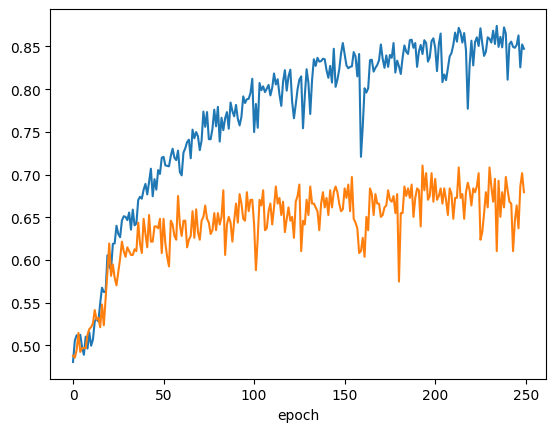

In [14]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

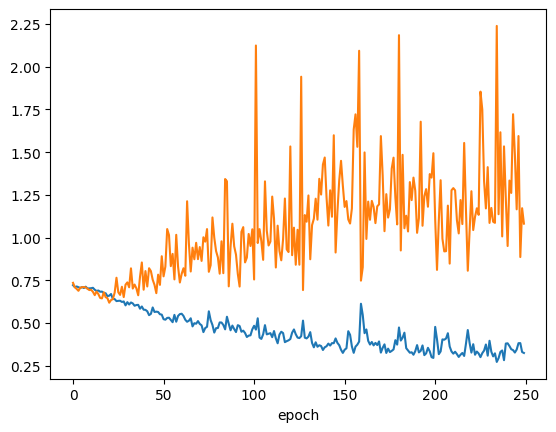

In [15]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

In [18]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # Remove the incorrect line attempting to use torch.max on labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Compare predicted directly to labels
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.6793
